In [81]:

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce GTX 1650 Ti


device(type='cuda', index=0)

# Part 2: TOY DATASET

Develop a toy dataset of $m$ sample points for Mixture of Gaussians (MoG):

*   Feature dimensions: 2
*   Number of Gaussian components: 3
*   Means: random
*   Covariance matrices: diagonal
*   Create visualizations for dataset

# 2.1 Dataset generation code

import supporting libraries

In [62]:
import numpy as np

function to produce toy dataset

here
* m = number of samples
* n_components = number of gaussian compononents
* n_features = number(dimensions) of features

this function returns
* X = data points in shape (m, n_features)
* y = component labels in shape (m, 1)
* means = true means of components in shape (n_components, n_features)

In [63]:
def produce_dataset(m, n_components, n_features):

    np.random.seed(6613)

    means = np.random.uniform(-10, 10, size=(n_components, n_features))

    #diagonal covariance
    covariances = [np.diag(np.random.uniform(1, 4, size=n_features)) for i in range(n_components)]

    weights = np.array([1/n_components] * n_components)
    points_per_component = (m * weights).astype(int)
    points_per_component[-1] = m - np.sum(points_per_component[:-1])

    X_cols = []
    y_cols = []

    for i in range(n_components):
        points = np.random.multivariate_normal(mean=means[i], cov=covariances[i], size=points_per_component[i])
        X_cols.append(points)
        y_cols.append(np.full(points_per_component[i], i))

    X = np.concatenate(X_cols)
    y = np.concatenate(y_cols)

    return X, y, means


using this function to satisfy our requirement

In [64]:
X_data, y_labels, means_data = produce_dataset(1000, 3, 2)

# 2.2 Visualizations

import supporting libraries

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

function to visualize raw 2-D dataset

In [66]:
def visualize_2d_raw(X):

    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], s=10, color='black')
    plt.title('Raw 2-D Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')
    plt.show()

function to visualize labeled 2-D dataset

In [67]:
def visualize_2d_labeled(X, y, means):

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='crest')
    plt.scatter(means[:, 0], means[:, 1], c='red', s=100, marker='*', label='True Means', edgecolors='black')
    plt.title('2-D Dataset with Labels')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(*scatter.legend_elements(), title='Components')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')
    plt.show()

function to produce 1-D histograms for each feature

In [68]:
def visualize_1d(X, y):

    n_features = X.shape[1]
    n_components = len(np.unique(y))
    palette = sns.color_palette('crest', n_components)

    fig, axes = plt.subplots(1, n_features, figsize=(14, 6))

    for i in range(n_features):
        ax = axes[i]
        sns.histplot(x=X[:, i], hue=y, multiple='stack', palette=palette, bins=30, alpha=0.7, ax=ax)
        ax.set_title(f'1D Visualization of Feature {i+1}')
        ax.set_xlabel(f'Feature {i+1}')
        ax.set_ylabel('Count / Density')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle('Marginal Distributions for Each Feature', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

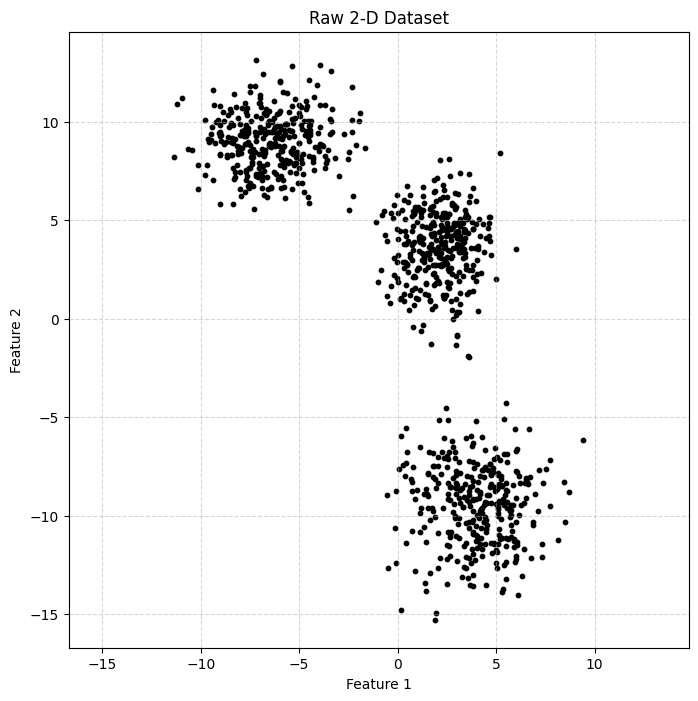

In [69]:
visualize_2d_raw(X_data)

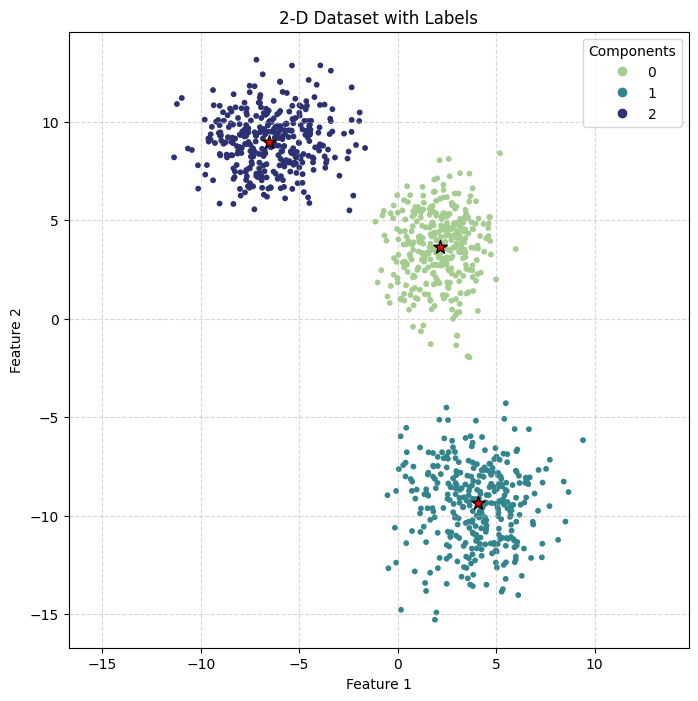

In [70]:
visualize_2d_labeled(X_data, y_labels, means_data)

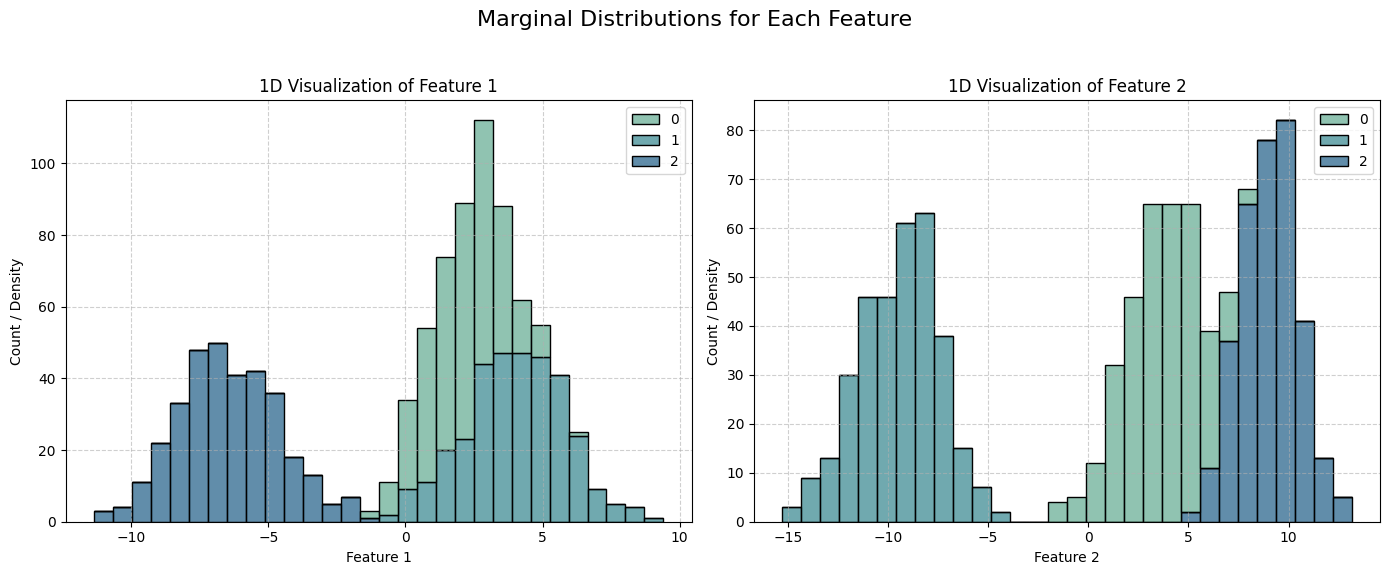

In [71]:
visualize_1d(X_data, y_labels)

# Part 3: DERIVATIONS

Given:

Likelihood for a point $x_i$
$$
p(x_i | \pi, \mu, \sigma^2) = \pi_1 \mathcal{N}(x_i | \mu_1,\sigma^2_1) + \pi_2 \mathcal{N}(x_i | \mu_2,\sigma^2_2)
\qquad\qquad(1)
$$

Log-likelihood for $m$ data points is
$$
\mathcal{L} = \sum_{i=1}^mlog(\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2))
\qquad\qquad(2)
$$
Responsibility of component $k$ for data point $i$ is
$$
\gamma_{ik} = \frac{\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}{\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)}
\qquad\qquad(3)
$$

# 3.1 Derivation of Mean Gradient



$$
\mathcal{L} = \sum_{i=1}^mlog(\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2))
$$

differntiating with respect to $\mu_k$
$$
\frac{\partial \mathcal{L}}{\partial \mu_k} = \frac{\partial}{\partial \mu_k} (\sum_{i=1}^mlog(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)))
$$
using sum rule
$$
\quad = \sum_{i=1}^m\frac{\partial}{\partial \mu_k} log(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2))
$$
using $\frac{d(logx)}{dx} = \frac{1}{x}$ and chain rule
$$
\quad = \sum_{i=1}^m\frac{1}{\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)}\frac{\partial}{\partial \mu_k}(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2))
$$
in the inner sum, our partial derivative only acts on the k-th term. rest are 0
$$
\quad = \sum_{i=1}^m\frac{1}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}\frac{\partial}{\partial \mu_k}\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)
$$
taking constant out
$$
\frac{\partial \mathcal{L}}{\partial \mu_k} = \sum_{i=1}^m\frac{\pi_k}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)} \frac{\partial}{\partial \mu_k}\mathcal{N}(x_i|\mu_k,\sigma_k^2) \qquad\qquad(4)
$$
we know that $\mathcal{N}(x_i|\mu_k,\sigma_k^2) = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}}$
then
$$
\frac{\partial}{\partial \mu_k}\mathcal{N}(x_i|\mu_k,\sigma_k^2) = \frac{\partial}{\partial \mu_k}(\frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}})
$$
$$
\quad = \frac{1}{\sqrt{2\pi\sigma_k^2}}\frac{\partial}{\partial \mu_k}(e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}})
$$
using $\frac{d(e^x)}{dx} = e^x$ and chain rule
$$
\quad = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}}\frac{\partial}{\partial \mu_k}(-\frac{(x_i - \mu_k)^2}{2\sigma^2_k})
$$
$$
\quad = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}}(-\frac{(x_i - \mu_k)}{2\sigma^2_k} * -2)
$$
$$
\quad = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}} * \frac{(x_i - \mu_k)}{\sigma^2_k}
$$
$$
\quad = \mathcal{N}(x_i|\mu_k,\sigma_k^2) * \frac{(x_i - \mu_k)}{\sigma^2_k} \qquad \qquad(5)
$$
using $(5)$ in $(4)$
$$
\frac{\partial \mathcal{L}}{\partial \mu_k}  = \sum_{i=1}^m\frac{\pi_k}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)} * \mathcal{N}(x_i|\mu_k,\sigma_k^2) * \frac{(x_i - \mu_k)}{\sigma^2_k}
$$
$$
\quad = \sum_{i=1}^m\frac{\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)} * \frac{(x_i - \mu_k)}{\sigma^2_k}
$$
or, using $(3)$
$$
{\frac{\partial \mathcal{L}}{\partial \mu_k}  = \sum_{i=1}^m\gamma_{ik} * \frac{(x_i - \mu_k)}{\sigma^2_k}}
$$

# 3.2 Derivation of Variance Gradient

$$
\mathcal{L} = \sum_{i=1}^mlog(\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2))
$$

differntiating with respect to $\sigma^2_k$
$$
\frac{\partial \mathcal{L}}{\partial\sigma^2_k} = \frac{\partial}{\partial \sigma^2_k} (\sum_{i=1}^mlog(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)))
$$
using sum rule
$$
\quad = \sum_{i=1}^m\frac{\partial}{\partial \sigma^2_k} log(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2))
$$
using $\frac{d(logx)}{dx} = \frac{1}{x}$ and chain rule
$$
\quad = \sum_{i=1}^m\frac{1}{\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)}\frac{\partial}{\partial \sigma^2_k}(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2))
$$
in the inner sum, our partial derivative only acts on the k-th term. rest are 0
$$
\quad = \sum_{i=1}^m\frac{1}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}\frac{\partial}{\partial \sigma^2_k}\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)
$$
taking constant out
$$
\frac{\partial \mathcal{L}}{\partial \sigma^2_k} = \sum_{i=1}^m\frac{\pi_k}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)} \frac{\partial}{\partial \sigma^2_k}\mathcal{N}(x_i|\mu_k,\sigma_k^2) \qquad\qquad(6)
$$
we know that $\mathcal{N}(x_i|\mu_k,\sigma_k^2) = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}}$
then
$$
\frac{\partial}{\partial \sigma_k^2}\mathcal{N}(x_i|\mu_k,\sigma_k^2) = \frac{\partial}{\partial \sigma_k^2}(\frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}})
$$
using product rule
$$ \quad = \frac{\partial}{\partial \sigma_k^2}(\frac{1}{\sqrt{2\pi\sigma_k^2}}) * e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}} + \frac{1}{\sqrt{2\pi\sigma_k^2}}*\frac{\partial}{\partial \sigma_k^2}(e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}})
$$
$$
= \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(x_i - \mu_k)^2}{2\sigma^2_k}} [\frac{(x_i - \mu_k)^2}{2(\sigma_k^2)^2} - \frac{1}{2 \sigma_k^2}]
$$
or
$$
\frac{\partial}{\partial \sigma_k^2}\mathcal{N}(x_i|\mu_k,\sigma_k^2) = \mathcal{N}(x_i|\mu_k,\sigma_k^2) * [\frac{(x_i - \mu_k)^2}{2(\sigma_k^2)^2} - \frac{1}{2 \sigma_k^2}] \qquad \qquad (7)
$$
using $(7)$ in $6$
$$
\frac{\partial \mathcal{L}}{\partial \sigma^2_k} = \sum_{i=1}^m\frac{\pi_k}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)} * \mathcal{N}(x_i|\mu_k,\sigma_k^2) * [\frac{(x_i - \mu_k)^2}{2(\sigma_k^2)^2} - \frac{1}{2 \sigma_k^2}]
$$
$$
= \sum_{i=1}^m\frac{\pi_k \mathcal{N}(x_i|\mu_k,\sigma_k^2)}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}[\frac{(x_i - \mu_k)^2}{2(\sigma_k^2)^2} - \frac{1}{2 \sigma_k^2}]
$$
using $(3)$
$$
= \sum_{i=1}^m\gamma_{ik}[\frac{(x_i - \mu_k)^2}{2(\sigma_k^2)^2} - \frac{1}{2 \sigma_k^2}]
$$
or
$$
\frac{\partial \mathcal{L}}{\partial \sigma^2_k} = \frac{1}{2} \sum_{i=1}^m\gamma_{ik}[\frac{(x_i - \mu_k)^2}{\sigma_k^4} - \frac{1}{ \sigma_k^2}]
$$

# 3.3 Derivation of Mixture weights gradient (with constraint $\sum_k \pi_k = 1$)
$$
\mathcal{L} = \sum_{i=1}^mlog(\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2))
$$

differntiating with respect to $\pi_k$
$$
\frac{\partial \mathcal{L}}{\partial \pi_k} = \frac{\partial}{\partial \pi_k} (\sum_{i=1}^mlog(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)))
$$
using sum rule
$$
\quad = \sum_{i=1}^m\frac{\partial}{\partial \mu_k} log(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2))
$$
using $\frac{d(logx)}{dx} = \frac{1}{x}$ and chain rule
$$
\quad = \sum_{i=1}^m\frac{1}{\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)}\frac{\partial}{\partial \mu_k}(\sum_{j=1}^2\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2))
$$
in the inner sum, our partial derivative only acts on the k-th term. rest are 0
$$
\quad = \sum_{i=1}^m\frac{1}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}\frac{\partial}{\partial \mu_k}\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)
$$
since $\pi_k$ is not in $\mathcal{N}(x_i|\mu_k,\sigma_k^2)$, the derivate is simply $\mathcal{N}(x_i|\mu_k,\sigma_k^2)$
$$
\quad = \sum_{i=1}^m\frac{\mathcal{N}(x_i|\mu_k,\sigma_k^2)}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}
$$
muiltiplying both numerator and denominator with $\pi_k$
$$
\quad = \sum_{i=1}^m \frac{1}{\pi_k} \frac{\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}{\sum_{k=1}^2\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}
$$
using $(3)$
$$
\frac{\partial \mathcal{L}}{\partial \pi_k} = \sum_{i=1}^m \frac{\gamma_{ik}}{\pi_k}
$$

# Part 4: SGD

import supporting libraries

In [72]:
import torch

set up required functions to initilize parameters, get parameters at any stage, calculate the probability distribution, responsibilities and gradients

In [73]:
def initialize_params(n_components, n_features):
                                                          #random initializations for our gaussian mizture models
    means = torch.randn(n_components, n_features)
    log_vars = torch.randn(n_components, n_features)      # initial value of L
    pi_k = torch.randn(n_components)                      # initial values of weights (pi_k)

    return means, log_vars, pi_k

def get_params(log_vars, pi_k):
                                                          # returns values of parameteres at any point
    variances = torch.exp(log_vars)                       #inverse of log function
    weights = torch.softmax(pi_k, dim=0)                  # softmax because we are constrained that sum of weights = 1

    return variances, weights

def gaussian_pdf(x, mean, variance):
                                                          #calculates N(x | mean, variance)
    n_features = x.shape[1]

                                                          # calculate the normalization constant: 1 / sqrt((2*pi)^k * det(Sigma))
    log_sigma = torch.sum(torch.log(variance))
    log_pi = -0.5 * (n_features * torch.log(torch.tensor(2 * np.pi)) + log_sigma)

                                                          # calculate the exponent term: -0.5 * (x - mu)^T * Sigma^-1 * (x - mu)
    diff = x - mean
    exponent = -0.5 * torch.sum(diff**2 / variance, dim=1)

    return torch.exp(log_pi + exponent)

def calculate_responsibilities(X_batch, means, log_vars, pi_k):
                                                          #calculates the responsibility function (gamma_ik)
    n_components = means.shape[0]
    variances, weights = get_params(log_vars, pi_k)

    weighted_pdfs = torch.zeros(X_batch.shape[0], n_components)
    for k in range(n_components):
        pdf = gaussian_pdf(X_batch, means[k], variances[k])
        weighted_pdfs[:, k] = weights[k] * pdf

    total_prob = torch.sum(weighted_pdfs, dim=1, keepdim=True)
    gamma_ik = weighted_pdfs / (total_prob + 1e-8)
    nll = -torch.sum(torch.log(total_prob + 1e-8))        #maintains the negative log loss

    return gamma_ik, nll.item()

def calculate_gradients(X_batch, gamma_ik, means, log_vars, pi_k):

    n_components = means.shape[0]
    variances, weights = get_params(log_vars, pi_k)

    grad_means = torch.zeros_like(means)
    grad_log_vars = torch.zeros_like(log_vars)
    grad_pi_k = torch.zeros_like(pi_k)

    for k in range(n_components):
        diff = X_batch - means[k]

                                                            # mean gradient
        grad_means[k] = -torch.sum(gamma_ik[:, k].unsqueeze(1) * diff / variances[k], dim=0)

                                                            # variance gradient
        term1 = (diff**2) / variances[k]
        grad_log_vars[k] = -0.5 * torch.sum(gamma_ik[:, k].unsqueeze(1) * (term1 - 1), dim=0)

                                                            # mixture weights gradient
        gamma_k_sum = torch.sum(gamma_ik[:, k])
        grad_pi_k[k] = -(gamma_k_sum - torch.sum(gamma_ik) * weights[k])

                                                            # normalize gradients by batch size for SGD
    return grad_means / X_batch.shape[0], grad_log_vars / X_batch.shape[0], grad_pi_k / X_batch.shape[0]

generate toy dataset of m=1000 3-D MoG with 3 components using our previously defined function

In [74]:
X_data_np, y_true_np, true_means = produce_dataset(m=1000, n_components=3, n_features=3)
X_data = torch.from_numpy(X_data_np).float()

initialize random GMM parameters as our starting point

In [75]:
n_components = 3
n_features = 3
means, log_vars, pi_k = initialize_params(n_components, n_features)

display initial state

In [76]:
initial_variances, initial_weights = get_params(log_vars, pi_k)
print("Initial Means:\n", means.detach().numpy())
print("\nInitial Variances (diagonal):\n", initial_variances.detach().numpy())
print("\nInitial Mixture Weights:\n", initial_weights.detach().numpy())

Initial Means:
 [[-1.4371527  -0.9123218   0.22500739]
 [ 1.6846206  -3.1144664   0.3213403 ]
 [ 0.48831087  0.9082843   0.8309834 ]]

Initial Variances (diagonal):
 [[0.8692956  0.76465356 2.752891  ]
 [1.4679786  0.8087812  0.57284105]
 [0.92044765 0.2863345  0.89247537]]

Initial Mixture Weights:
 [0.45579422 0.4056905  0.1385153 ]


model training

customize number of epochs, batch size and learning rate as required

In [77]:
n_epochs = 100
batch_size = 100
lr = 0.1

stoachatic gradient descent with NLL objective and diagonal covariance

In [78]:
n_samples = X_data.shape[0]

print("Starting SGD Training")
for epoch in range(n_epochs):
    permutation = torch.randperm(n_samples)
    X_shuffled = X_data[permutation]

    epoch_nll = 0

    for i in range(0, n_samples, batch_size):
        X_batch = X_shuffled[i : i + batch_size]

                                                                  #Calculate responsibilities and negative log loss
        gamma_ik, nll = calculate_responsibilities(X_batch, means, log_vars, pi_k)
        epoch_nll += nll

                                                                  # Calculate gradients
        grad_means, grad_log_vars, grad_weight_logits = calculate_gradients(X_batch, gamma_ik, means, log_vars, pi_k)

        # SGD Update Step
        means -= lr * grad_means
        log_vars -= lr * grad_log_vars
        pi_k -= lr * pi_k

    avg_nll = epoch_nll / n_samples
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, NLL: {avg_nll:.4f}")

Starting SGD Training
Epoch 10/100, NLL: 9.8649


Epoch 20/100, NLL: 9.0606
Epoch 30/100, NLL: 8.6485
Epoch 40/100, NLL: 8.3933
Epoch 50/100, NLL: 8.1751
Epoch 60/100, NLL: 7.9713
Epoch 70/100, NLL: 7.8524
Epoch 80/100, NLL: 7.7953
Epoch 90/100, NLL: 7.7540
Epoch 100/100, NLL: 7.7161


final state

In [79]:
final_variances, final_weights = get_params(log_vars, pi_k)
print("Final Learned Means:\n", means.detach().numpy())
print("\nFinal Learned Variances (diagonal):\n", final_variances.detach().numpy())
print("\nFinal Learned Mixture Weights:\n", final_weights.detach().numpy())

Final Learned Means:
 [[-8.078688   -3.4729612   8.730795  ]
 [ 1.5943692  -2.930427    0.5452191 ]
 [-0.09656887  2.978598    5.072201  ]]

Final Learned Variances (diagonal):
 [[ 5.3999553  15.585221    2.4660125 ]
 [ 1.6052544   0.9581517   0.67751765]
 [11.887274    2.9426773   3.225353  ]]

Final Learned Mixture Weights:
 [0.33333334 0.33333334 0.33333334]


compare to true value

In [80]:
print(true_means)

[[ 2.14598426  3.61351717  4.06036832]
 [-9.3511145  -6.5221725   8.97566243]
 [-4.07201903  2.14260776  6.75558389]]
